In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from math import exp
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis

Lets import both the header and the data for this model

In [2]:
names = pd.read_csv('../data/census_data/census-bureau.columns') #Load the header names into a dataframe
df = pd.read_csv('../data/census_data/census-bureau.data', names = names['age']) #Load the data in with the names being the first column of the header dataframe
df = df.reset_index(drop = False, names = 'age') #Since age was loaded in as the index we will reset the index and name its column "age"

View the dataframe to ensure that all headers and data line up

In [3]:
df

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
199519,65,Self-employed-incorporated,37,2,11th grade,0,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
199520,47,Not in universe,0,0,Some college but no degree,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,Poland,Poland,Germany,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,95,- 50000.
199521,16,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.


Lets confirm all of the columns we have available to us

In [4]:
df.columns

Index(['age', 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household', 'weight',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
       'ow

Lets first do some housekeeping items here such as joining together column names with an underscore and changing the labels to be in a more friendly format

In [5]:
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns] #List comprehension to strip whitespace, convert to lowercase and add _ between words

In [6]:
df['label'] = np.where(df['label']=='- 50000.', '<50', '>50') #Replace all instances of greater or less than 50000 with either <50 or >50

In [7]:
df['label'].value_counts(normalize=True)

label
<50    0.937942
>50    0.062058
Name: proportion, dtype: float64

It looks like we have significant class imbalance in the dataset with around 94% of the rows belonging to the <50 class so we are going to need to find a way to account for this. Lets now do a quick df.describe to see the typical range of values for each of the numerical columns

In [8]:
df.describe()

,age,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,weight,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


A few things stand out here. It looks like the money related columns such as wage, capital gains and losses and dividends are all mostly 0s since their 75th percentile values are all zeros. In addition, we can see that weight clearly isnt the weight of a person and it is what was stated in the problem statement as a proportion of the people similar to this person. Age also has a minimum value of zero so there are clearly some values that do not belong in the dataset. There are also a few variables that have values that seem to be misleading. For example, num_persons_worked_for_employer seems to range from 0 to 6 probably signifying it being classified into buckets. Other variables such as veteran benefits exhibit similar behavior

Lets now create a few exploratory charts that can give us an idea of the data we have. Lets first look at the distribution of age in the dataset and how it might relate to the class label

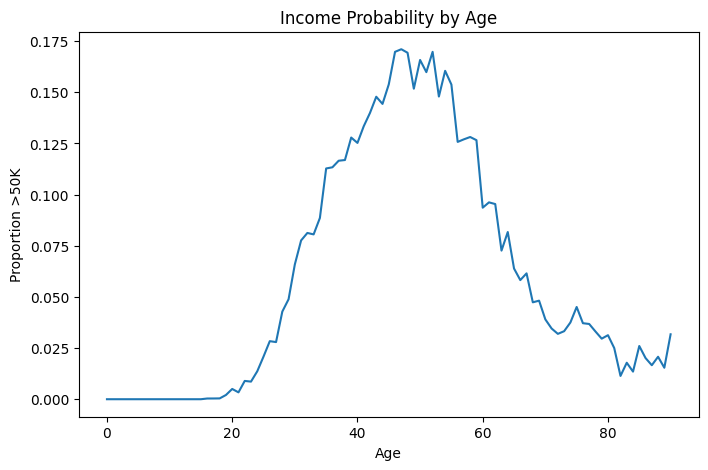

In [9]:
age_income = df.groupby('age')['label'].apply(lambda x: (x == '>50').mean())

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(age_income.index, age_income.values)

ax.set_xlabel("Age")
ax.set_ylabel("Proportion >50K")
ax.set_title("Income Probability by Age")
plt.show()

It seems like after age 20, the likelihood of income greater than $50,000 increases signficantly and then begins to decrease once someone reaches close to 60 years old

/var/folders/d8/29ff9cz17g5blxpv2039mrj80000gn/T/ipykernel_67606/1277317410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['age_bucket', 'sex'])['label']


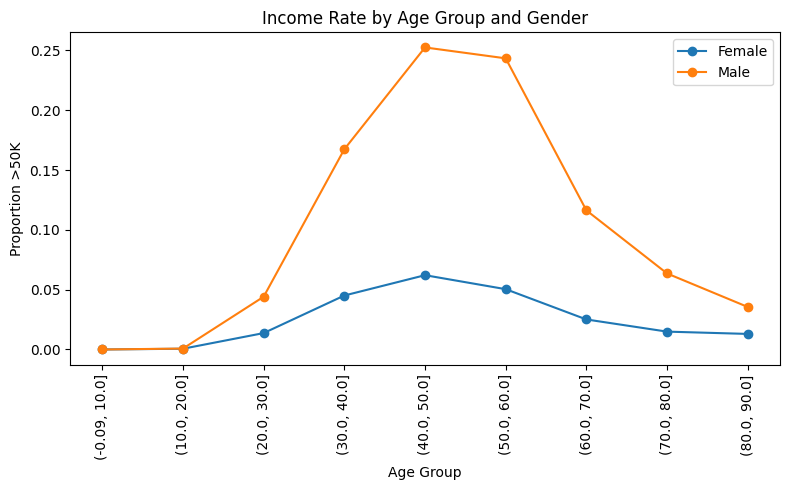

In [10]:
df['age_bucket'] = pd.cut(df['age'], bins=9)

# Compute income rate per age bucket and gender
age_gender_income = (
    df.groupby(['age_bucket', 'sex'])['label']
      .apply(lambda x: (x == '>50').mean())
      .unstack()
)

fig, ax = plt.subplots(figsize=(8,5))

for gender in age_gender_income.columns:
    ax.plot(age_gender_income.index.astype(str),
            age_gender_income[gender],
            marker='o',
            label=gender)

ax.set_xlabel("Age Group")
ax.set_ylabel("Proportion >50K")
ax.set_title("Income Rate by Age Group and Gender")
plt.xticks(rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

When separatong by gender we see the same trends in terms of likelihood of making over $50,000 as age increases past 20, however, there are significant differences in the proportions between males and females

Lets take a look at the marital status and citizenship

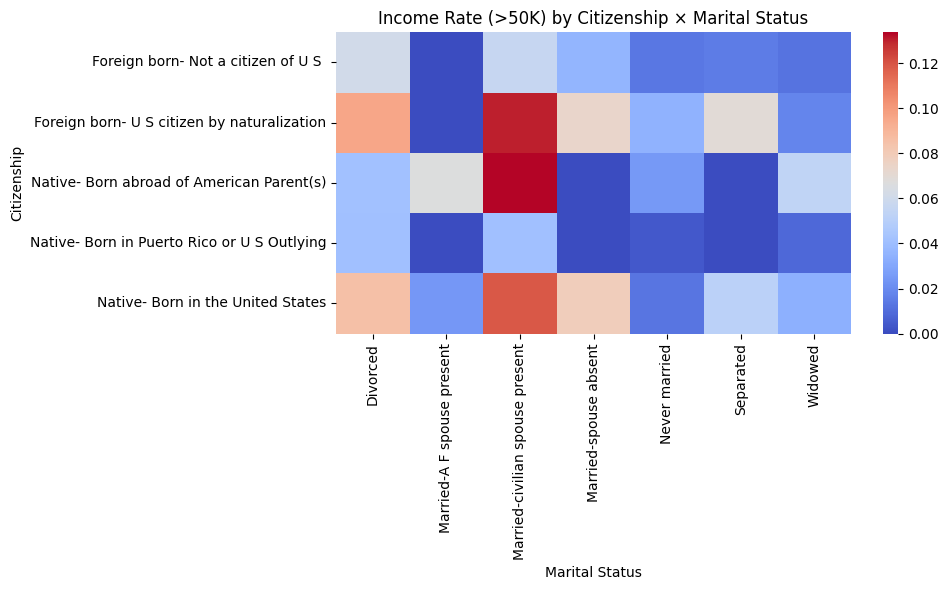

In [11]:
heat = pd.pivot_table(
    df,
    values="label",
    index="citizenship",
    columns="marital_stat",
    aggfunc=lambda x: (x == ">50").mean()
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heat, cmap="coolwarm", annot=False, ax=ax)
ax.set_title("Income Rate (>50K) by Citizenship × Marital Status")
ax.set_xlabel("Marital Status")
ax.set_ylabel("Citizenship")
plt.tight_layout()
plt.show()

There does not seem to be much we can gather from this chart. As anticipated, married individuals who are also citizens tend to make north of $50,000 while those who are not married or are previously married typically make less than $50,000

Since it looks like most of the values are zero in the money related columns, lets visualize the folks who have zeros for these values and those who do not

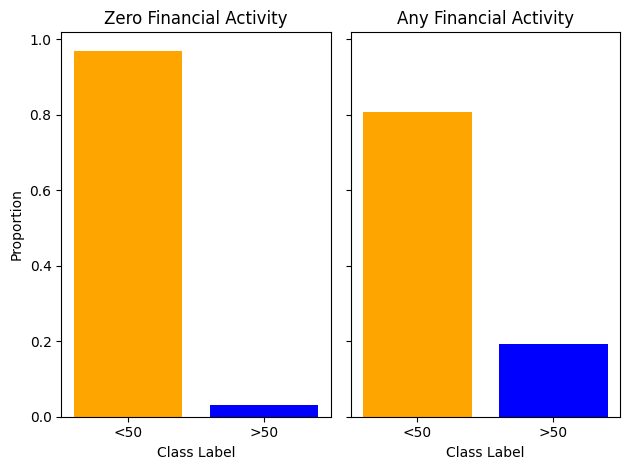

In [12]:
money_cols = [
    'wage_per_hour',
    'capital_gains',
    'capital_losses',
    'dividends_from_stocks'
]

df_0 = df.loc[(df[money_cols]==0).all(axis = 1)]
df_1 = df.loc[(df[money_cols] != 0).any(axis=1)]

counts_0 = df_0['label'].value_counts(normalize = True)
counts_1 = df_1['label'].value_counts(normalize = True)

fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].bar(counts_0.index, counts_0.values, color = ['orange', 'blue'])
ax[1].bar(counts_1.index, counts_1.values, color = ['orange', 'blue'])
ax[0].set_xlabel('Class Label')
ax[1].set_xlabel('Class Label')
ax[0].set_ylabel("Proportion")
ax[0].set_title("Zero Financial Activity")
ax[1].set_title("Any Financial Activity")
plt.tight_layout()
plt.show()

We can see from this that zero financial activity from a person is a good indication that a person does not make more than 50,000 as the proportion of people with zero financial activity and less than 50,000 in income is around 96 percent. Conversely the proportion of people that have any financial activity and make more than 50,000 dollars is signficantly higher than people with zero financial activity. 

Lets now explore education and how it relates to income

/var/folders/d8/29ff9cz17g5blxpv2039mrj80000gn/T/ipykernel_67606/726918904.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_edu.index, rotation=90)


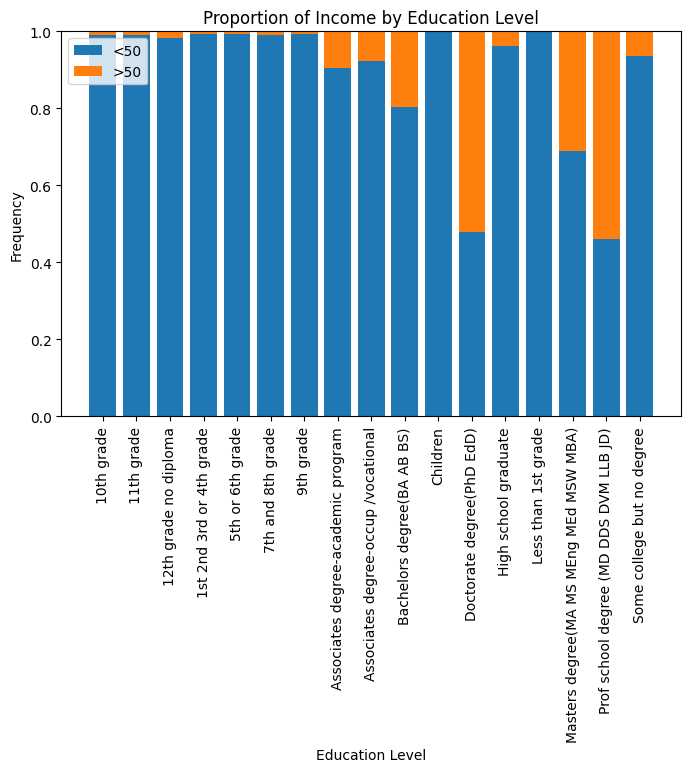

In [13]:
fig, ax = plt.subplots(figsize = (8, 5))

df_edu = pd.crosstab(df['education'], df['label'], normalize = 'index')
ax.bar(df_edu.index, df_edu['<50'], label='<50')
ax.bar(df_edu.index, df_edu['>50'], bottom=df_edu['<50'], label='>50')
ax.set_xlabel('Education Level')
ax.set_ylabel('Frequency')
ax.set_xticklabels(df_edu.index, rotation=90)
ax.set_title('Proportion of Income by Education Level')
ax.legend()
plt.show()

Based on this we can clearly see that most people in the dataset that achieved higher level degrees make more than 50,000 in the dataset. The frequency of people who make more than 50,000 for those that did not go to college is significantly less. 

Another variable I would expect to have high correlation with income is occupation, so lets explore those values. There are several columns related to occupation in the dataset so I want to take a look at the unique values of each to see what each of them encodes

Lets first take a look at the major occupation code

/var/folders/d8/29ff9cz17g5blxpv2039mrj80000gn/T/ipykernel_67606/1966000286.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_occ.index, rotation=90)


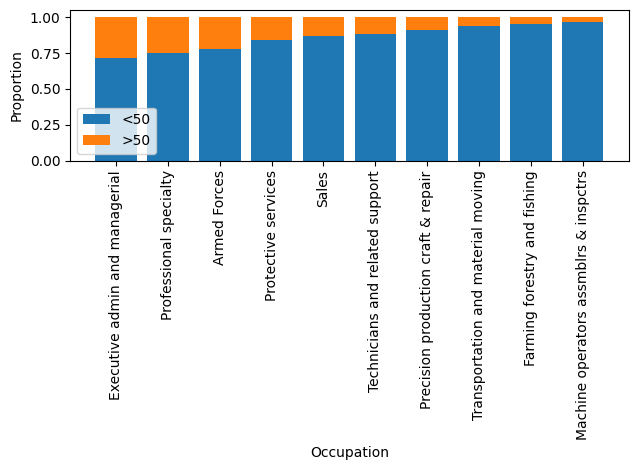

In [14]:
df_occ = pd.crosstab(df['major_occupation_code'], df['label'], normalize = 'index')

df_occ = df_occ.sort_values('>50', ascending = False).head(10)

fig, ax = plt.subplots()

ax.bar(df_occ.index, df_occ['<50'], label='<50')

ax.bar(df_occ.index, df_occ['>50'], bottom=df_occ['<50'], label='>50')

ax.set_xlabel('Occupation')
ax.set_ylabel('Proportion')

ax.set_xticklabels(df_occ.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

We can see here there are a few occupations that clearly signal more income than others, however, no single occupation seems to have more than around 30% of its proportion making over $50,000

Lets now take a look at the industry code

/var/folders/d8/29ff9cz17g5blxpv2039mrj80000gn/T/ipykernel_67606/3633832539.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_ind.index, rotation=90)


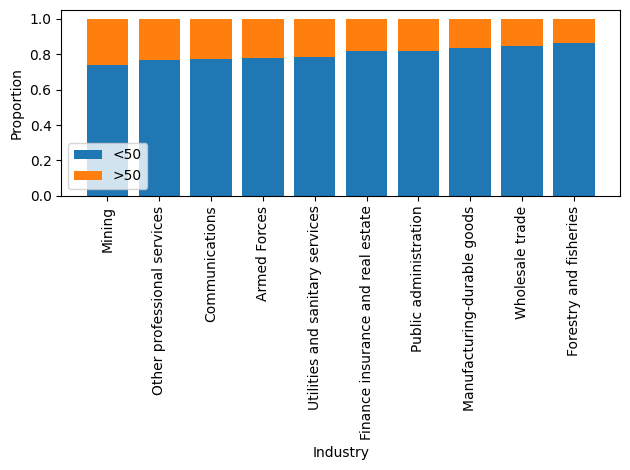

In [15]:
df_ind = pd.crosstab(df['major_industry_code'], df['label'], normalize = 'index')

df_ind = df_ind.sort_values('>50', ascending = False).head(10)

fig, ax = plt.subplots()


ax.bar(df_ind.index, df_ind['<50'], label='<50')


ax.bar(df_ind.index, df_ind['>50'], bottom=df_ind['<50'], label='>50')


ax.set_xlabel('Industry')
ax.set_ylabel('Proportion')

ax.set_xticklabels(df_ind.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

This is similar to the occupation where a select few have higher rates than others but seems to be mostly stable across the board.

Lets now look at the class of worker

/var/folders/d8/29ff9cz17g5blxpv2039mrj80000gn/T/ipykernel_67606/4090693902.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_cla.index, rotation=90)


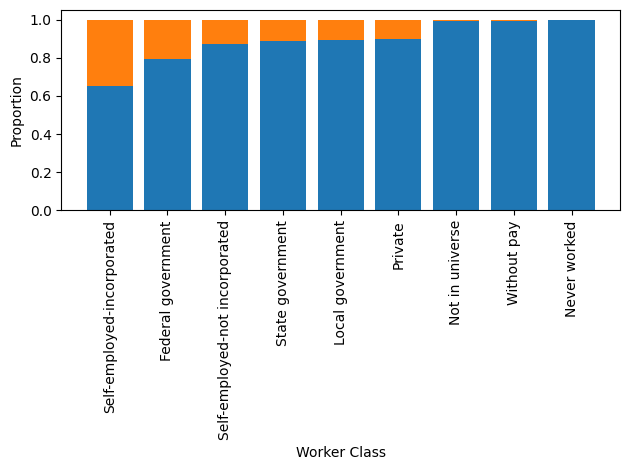

In [16]:
df_cla = pd.crosstab(df['class_of_worker'], df['label'], normalize = 'index')

df_cla = df_cla.sort_values('>50', ascending = False)

fig, ax = plt.subplots()

ax.bar(df_cla.index, df_cla['<50'], label='<50')

ax.bar(df_cla.index, df_cla['>50'], bottom=df_cla['<50'], label='>50')

ax.set_xlabel('Worker Class')
ax.set_ylabel('Proportion')
ax.set_xticklabels(df_cla.index, rotation=90)
ax.set_ylabel('Proportion')
plt.tight_layout()
plt.show()

Here there is a little more disparity where the top 3-5 categories have significantly higher rates of people making over 50,000. This may make this column slightly more informative than the other two

Lets also create a correlation heatmap of our numeric columns to see if there is any redundancy

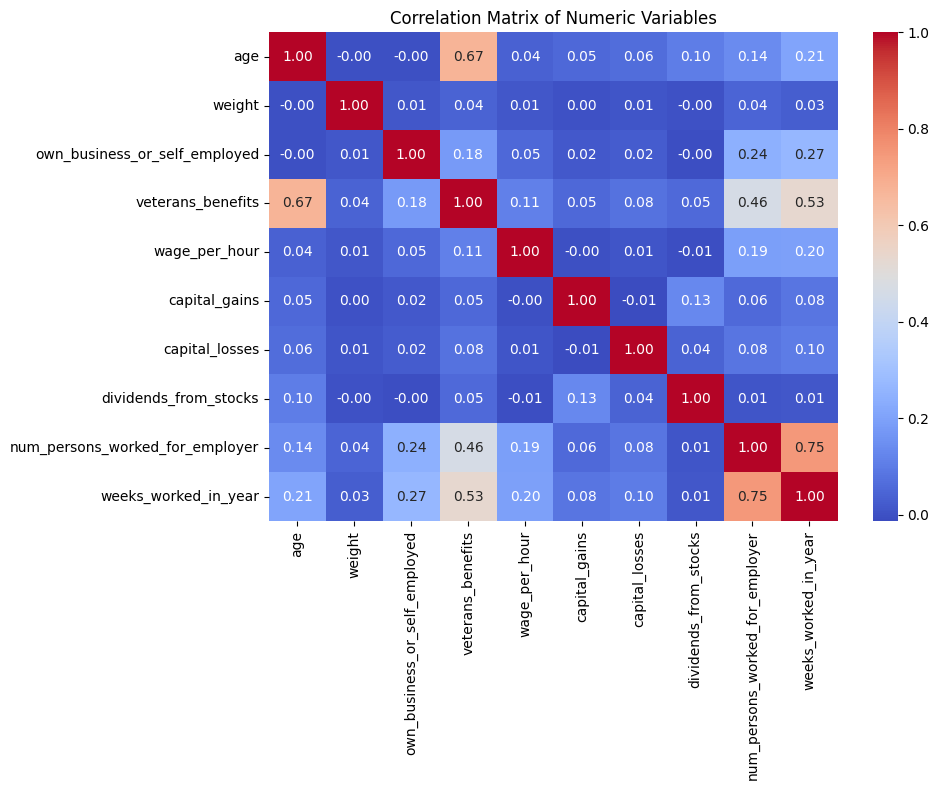

In [17]:
numerical = [ #Create the list of numerical variables
    'age',
    'weight',
    'own_business_or_self_employed',
    'veterans_benefits',
    'wage_per_hour',
    'capital_gains',
    'capital_losses',
    'dividends_from_stocks',
    'num_persons_worked_for_employer',
    'weeks_worked_in_year'
]

corr = df[numerical].corr()

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt = ".2f", ax=ax)
ax.set_title("Correlation Matrix of Numeric Variables")
plt.tight_layout()
plt.show()

We can see here that many variables do not have the strongest of correlation in either direction between each other. One of the highest positive correlation between 2 variables is veterans benefits and age which makes sense since the older a person is the more likely they had served in the military in the past and are now receiving veteran benefits. Another interesting correlation occurs between number of people worked for and weeks worked in a year. This may represent persons who work for larger companies in a full time role.

## Data Cleaning

As a first pass at reducing any inconsistency we have in the dataset lets filter out any people under the age of 20 from the dataset. We saw from the analysis above that there are no people in the dataset that make above 50,000 dollars and are age 19 and younger. This makes sense as it is very unlikely these folks will be working or be making over 50,000 dollars at this point in their life especially in 1994 and 1995. We can first see how many people this applies to by filtering specifically to those who are under 20 and make less than 50000 dollars. This will likely also help us to reduce the class imbalance in the dataset. We also likely wouldnt target folks less than 20 years old in a marketing campaign to purchase items

In [18]:
len(df[(df['age']<20) & (df['label']=='<50')])

60887

In [19]:
df = df[df['age']>=20]

Lets check the updated class imbalance after dropping these rows

In [20]:
df['label'].value_counts(normalize = True)

label
<50    0.91074
>50    0.08926
Name: proportion, dtype: float64

Ok it looks like filtering out people less than 20 years old actually helped us with class imbalance as we were able to reduce the less than 50,000 class by about 60,000 people. We still have a significant amount of class imbalance so we are going to need to take that into account when we implement our final model

Based on this initial look, it seems like there are several values that are represented by values classified as either "not in universe" or "?". I believe this means the specific column is not applicable to the person which is essentially an NA value. Lets first count the number of NA values pandas can see and then we will count how many of the not in universe or ? values there are to see if there are columns that contain mostly these values. If a column contains mostly these values then it likely will not provide us with a significant signal in the final model

In [21]:
df.isna().sum()

age                                             0
class_of_worker                                 0
detailed_industry_recode                        0
detailed_occupation_recode                      0
education                                       0
wage_per_hour                                   0
enroll_in_edu_inst_last_wk                      0
marital_stat                                    0
major_industry_code                             0
major_occupation_code                           0
race                                            0
hispanic_origin                               650
sex                                             0
member_of_a_labor_union                         0
reason_for_unemployment                         0
full_or_part_time_employment_stat               0
capital_gains                                   0
capital_losses                                  0
dividends_from_stocks                           0
tax_filer_stat                                  0


As I had expected, pandas did not recognize many of the columns to have any NA values other than the hispanic origin column, so we are going to have to count the number of not in universe or ? values for each column

In [22]:
lst = []

for col in df.columns:
    if df[col].dtype == "object":  # ensure it's string-like
        count_1 = df[col].str.contains("?", na=False, regex = False).sum() # 
        count_2 = df[col].str.contains("Not in universe", case = False, na=False).sum()
        count = count_1 + count_2
        lst.append((col, count))
lst

[('class_of_worker', np.int64(45226)),
 ('education', np.int64(0)),
 ('enroll_in_edu_inst_last_wk', np.int64(134531)),
 ('marital_stat', np.int64(0)),
 ('major_industry_code', np.int64(45339)),
 ('major_occupation_code', np.int64(45339)),
 ('race', np.int64(0)),
 ('hispanic_origin', np.int64(0)),
 ('sex', np.int64(0)),
 ('member_of_a_labor_union', np.int64(120591)),
 ('reason_for_unemployment', np.int64(133558)),
 ('full_or_part_time_employment_stat', np.int64(0)),
 ('tax_filer_stat', np.int64(0)),
 ('region_of_previous_residence', np.int64(127701)),
 ('state_of_previous_residence', np.int64(128216)),
 ('detailed_household_and_family_stat', np.int64(0)),
 ('detailed_household_summary_in_household', np.int64(0)),
 ('migration_code-change_in_msa', np.int64(69336)),
 ('migration_code-change_in_reg', np.int64(69336)),
 ('migration_code-move_within_reg', np.int64(69336)),
 ('live_in_this_house_1_year_ago', np.int64(69336)),
 ('migration_prev_res_in_sunbelt', np.int64(127701)),
 ('family_mem

We can see there are a significant amount of columns that contain several "Not in universe" and "?" values. We are going to drop any columns that have more than 40% of their values as NA. Many of these variables above are ones that are likely not great to impute values for considering several categorical variables have many different values and the numerical variables can  give strong signal

Lets now develop the code to drop any columns that have more than 40% NA values

In [23]:
cols_to_drop = []
for column, val in lst:
    if val/len(df)>0.40:
        cols_to_drop.append(column)
cols_to_drop

['enroll_in_edu_inst_last_wk',
 'member_of_a_labor_union',
 'reason_for_unemployment',
 'region_of_previous_residence',
 'state_of_previous_residence',
 'migration_code-change_in_msa',
 'migration_code-change_in_reg',
 'migration_code-move_within_reg',
 'live_in_this_house_1_year_ago',
 'migration_prev_res_in_sunbelt',
 'family_members_under_18',
 "fill_inc_questionnaire_for_veteran's_admin"]

We can see there are several columns that fit the criteria of more than 40% NA values, so we are going to drop these to reduce model complexity. If there are columns left that still have NA values, then we will leave those be because they may be able to provide us with useful signal such as not in universe values for the occupation column which can tell us the person is currently not working

In [24]:
df = df.drop(columns = cols_to_drop)

Lets check the columns that are remaining now

In [25]:
df.columns

Index(['age', 'class_of_worker', 'detailed_industry_recode',
       'detailed_occupation_recode', 'education', 'wage_per_hour',
       'marital_stat', 'major_industry_code', 'major_occupation_code', 'race',
       'hispanic_origin', 'sex', 'full_or_part_time_employment_stat',
       'capital_gains', 'capital_losses', 'dividends_from_stocks',
       'tax_filer_stat', 'detailed_household_and_family_stat',
       'detailed_household_summary_in_household', 'weight',
       'num_persons_worked_for_employer', 'country_of_birth_father',
       'country_of_birth_mother', 'country_of_birth_self', 'citizenship',
       'own_business_or_self_employed', 'veterans_benefits',
       'weeks_worked_in_year', 'year', 'label', 'age_bucket'],
      dtype='object')

There are several columns in the dataset that at first glance look to be very redundant. For example, it seems unlikely we will need separate columns for the birth country of the mother, father and the person in question. Lets take a look at some of the unique values of columns that seem to be redundant in nature to see if we can drop columns that are likely correlated with one another or give unuseful information

In [26]:
df['country_of_birth_father'].unique()

array(['United-States', 'Philippines', '?', 'Columbia', 'Germany',
       'Mexico', 'Japan', 'Peru', 'Cuba', 'Vietnam', 'Dominican-Republic',
       'El-Salvador', 'Canada', 'Scotland', 'Italy', 'Guatemala',
       'Ecuador', 'Outlying-U S (Guam USVI etc)', 'Puerto-Rico',
       'Cambodia', 'China', 'Poland', 'Nicaragua', 'Taiwan', 'England',
       'Ireland', 'Hungary', 'Yugoslavia', 'South Korea',
       'Trinadad&Tobago', 'Jamaica', 'Honduras', 'Portugal', 'Iran',
       'France', 'India', 'Hong Kong', 'Haiti', 'Holand-Netherlands',
       'Thailand', 'Greece', 'Laos', 'Panama'], dtype=object)

In [27]:
df['country_of_birth_mother'].unique()

array(['United-States', '?', 'Columbia', 'Mexico', 'Peru', 'Cuba',
       'Philippines', 'Vietnam', 'Dominican-Republic', 'El-Salvador',
       'Germany', 'England', 'Scotland', 'Italy', 'Guatemala', 'Ecuador',
       'Puerto-Rico', 'China', 'Poland', 'Hungary', 'Nicaragua', 'Taiwan',
       'Ireland', 'Canada', 'Yugoslavia', 'South Korea',
       'Trinadad&Tobago', 'Jamaica', 'Honduras', 'Portugal', 'Iran',
       'France', 'Cambodia', 'India', 'Hong Kong', 'Haiti', 'Japan',
       'Holand-Netherlands', 'Greece', 'Thailand',
       'Outlying-U S (Guam USVI etc)', 'Laos', 'Panama'], dtype=object)

In [28]:
df['country_of_birth_self'].unique()

array(['United-States', '?', 'Columbia', 'Mexico', 'Peru', 'Cuba',
       'Philippines', 'Vietnam', 'Dominican-Republic', 'El-Salvador',
       'Canada', 'Scotland', 'Guatemala', 'Ecuador', 'Germany',
       'Outlying-U S (Guam USVI etc)', 'Puerto-Rico', 'Italy', 'China',
       'Poland', 'Nicaragua', 'Taiwan', 'England', 'Ireland',
       'South Korea', 'Trinadad&Tobago', 'Jamaica', 'Honduras', 'Iran',
       'Hungary', 'France', 'Cambodia', 'India', 'Hong Kong', 'Japan',
       'Haiti', 'Holand-Netherlands', 'Greece', 'Thailand', 'Yugoslavia',
       'Portugal', 'Laos', 'Panama'], dtype=object)

In [29]:
df['citizenship'].unique()

array(['Native- Born in the United States',
       'Foreign born- Not a citizen of U S ',
       'Foreign born- U S citizen by naturalization',
       'Native- Born abroad of American Parent(s)',
       'Native- Born in Puerto Rico or U S Outlying'], dtype=object)

Looking at the columns above, it seems very likely we will only keep citizenship and drop the birth country columns. Citizenship essentially already covers the birth country so it will provide enough information for us on that end. It may be useful to combine this into a binary variable of citizen and not a citizen since we likely do not need the level of depth this variable already provides

In [30]:
df['detailed_household_and_family_stat'].unique()

array(['Other Rel 18+ ever marr not in subfamily', 'Householder',
       'Spouse of householder', 'Secondary individual',
       'Other Rel 18+ never marr not in subfamily',
       'Nonfamily householder', 'Child 18+ never marr Not in a subfamily',
       'Child 18+ ever marr Not in a subfamily',
       'Child 18+ never marr RP of subfamily',
       'Child 18+ spouse of subfamily RP',
       'Grandchild 18+ never marr not in subfamily',
       'Child 18+ ever marr RP of subfamily',
       'Other Rel 18+ ever marr RP of subfamily',
       'RP of unrelated subfamily',
       'Other Rel 18+ spouse of subfamily RP', 'In group quarters',
       'Grandchild 18+ spouse of subfamily RP',
       'Other Rel 18+ never marr RP of subfamily',
       'Grandchild 18+ ever marr not in subfamily',
       'Spouse of RP of unrelated subfamily',
       'Grandchild 18+ never marr RP of subfamily',
       'Grandchild 18+ ever marr RP of subfamily'], dtype=object)

In [31]:
df['detailed_household_summary_in_household'].unique()

array(['Other relative of householder', 'Householder',
       'Spouse of householder', 'Nonrelative of householder',
       'Child 18 or older', 'Group Quarters- Secondary individual'],
      dtype=object)

We will likely only keep the summary in household column here as the family stat column simply contains too many different values to provide the model with useful signal

In [32]:
df['tax_filer_stat'].unique()

array(['Nonfiler', 'Head of household', 'Joint both under 65', 'Single',
       'Joint both 65+', 'Joint one under 65 & one 65+'], dtype=object)

We have a slight overlap between the three previous variables we just printed along with the marital status. The family status simply provides us with too many values for it to be useful and then some of this information can also be covered in the related summary in household column. Lastly tax filer status also essentially states the marital status of a person, so we will likely drop all 3 of these columns and keep the marital status column 

In [33]:
df['full_or_part_time_employment_stat'].unique()

array(['Not in labor force', 'Children or Armed Forces',
       'Full-time schedules', 'Unemployed full-time',
       'Unemployed part- time', 'PT for non-econ reasons usually FT',
       'PT for econ reasons usually PT', 'PT for econ reasons usually FT'],
      dtype=object)

this almost certainly contains values that we can combine into one category such as not in labor force and unemployed full time

In [34]:
df['class_of_worker'].unique()

array(['Not in universe', 'Self-employed-not incorporated', 'Private',
       'Local government', 'Federal government',
       'Self-employed-incorporated', 'State government', 'Without pay',
       'Never worked'], dtype=object)

Again there are values in here that we can combine such as never worked and without pay

In [35]:
df['major_industry_code'].unique()

array(['Not in universe or children', 'Construction', 'Entertainment',
       'Finance insurance and real estate', 'Education',
       'Business and repair services', 'Manufacturing-nondurable goods',
       'Personal services except private HH',
       'Manufacturing-durable goods', 'Other professional services',
       'Mining', 'Transportation', 'Wholesale trade',
       'Public administration', 'Retail trade', 'Social services',
       'Private household services', 'Utilities and sanitary services',
       'Communications', 'Hospital services', 'Medical except hospital',
       'Agriculture', 'Forestry and fisheries', 'Armed Forces'],
      dtype=object)

In [36]:
df['major_industry_code'].value_counts(normalize = True)

major_industry_code
Not in universe or children            0.327055
Retail trade                           0.102714
Manufacturing-durable goods            0.063905
Education                              0.057658
Manufacturing-nondurable goods         0.048324
Finance insurance and real estate      0.043620
Construction                           0.041860
Business and repair services           0.038852
Public administration                  0.032944
Medical except hospital                0.032778
Other professional services            0.031530
Transportation                         0.029951
Hospital services                      0.028342
Wholesale trade                        0.025204
Personal services except private HH    0.020032
Agriculture                            0.019938
Social services                        0.017276
Entertainment                          0.010027
Utilities and sanitary services        0.008404
Communications                         0.008397
Private household se

In [37]:
df['major_occupation_code'].value_counts(normalize = True)

major_occupation_code
Not in universe                          0.327055
Adm support including clerical           0.102606
Professional specialty                   0.099309
Executive admin and managerial           0.089636
Sales                                    0.075829
Other service                            0.074545
Precision production craft & repair      0.074393
Machine operators assmblrs & inspctrs    0.044637
Transportation and material moving       0.028385
Handlers equip cleaners etc              0.024981
Technicians and related support          0.021532
Farming forestry and fishing             0.020595
Protective services                      0.011635
Private household services               0.004631
Armed Forces                             0.000231
Name: proportion, dtype: float64

Based on the industry and occupation codes, there seems to be several different values for each that occur much less frequently compared to the rest. We may need to combine these into an other category later

In [38]:
df['num_persons_worked_for_employer'].unique()

array([0, 1, 6, 4, 5, 3, 2])

This column seems to be a categorical variable representing company size, so we will need to ensure we include this as a categorical variable in the pipeline

In [39]:
df['marital_stat'].unique()

array(['Widowed', 'Divorced', 'Married-civilian spouse present',
       'Never married', 'Separated', 'Married-spouse absent',
       'Married-A F spouse present'], dtype=object)

Based on viewing the unique values of the variables above, we are going to drop several columns that I believe to be either unuseful or correlated with other variables in the dataset. We are also going to drop the age bucket, year and weight columns. The year will not provide us with any useful signal, age bucket is already covered by the age column and I do not want to create another categorical variable. Then we will also drop weight because this only implies the proportion of people with similar characteristics which does not have much to do with if these people have an income greater than $50,000

In [40]:
df = df.drop(columns = [
    'country_of_birth_self',
    'country_of_birth_mother',
    'country_of_birth_father',
    'detailed_occupation_recode',
    'detailed_industry_recode',
    'detailed_household_and_family_stat',
    'hispanic_origin',
    'weight',
    'own_business_or_self_employed',
    'detailed_household_summary_in_household',
    'tax_filer_stat',
    'year',
    'age_bucket'])

## Feature Engineering

Great lets now implement changes to the columns that were mentioned above such as condensing specific columns into fewer categories. We will first start by combining the education column. This will combine the education column into 4 distinct categories since there were several instances in which the education level was 7th grade, 8th grade, 9th grade etc. This will hopefully reduce model complexity and improve prediction accuracy

In [41]:
def group_education(edu):
    edu = str(edu).lower()
    
    # Advanced Degrees
    if any(x in edu for x in ['masters', 'doctorate', 'prof school']):
        return 'advanced_degree'
    
    # College (Bachelors)
    elif 'bachelors' in edu:
        return 'college'
    
    # Some College / Associates
    elif 'some college' in edu or 'associates' in edu:
        return 'some_college'
    
    # High School and everything below
    else:
        return 'high_school_or_less'

# Apply the grouping
df['education_grouped'] = df['education'].apply(group_education)

df = df.drop(columns = ['education'])

Great lets now combine the citizenship into a binary variable representing the person either being a US citizen or not a US citizen. Before there were 5 different classes describing citizenship that included unnessecary detail on the person's citizenship

In [42]:
def group_citizenship(edu):
    edu = str(edu).lower()
    
    # Advanced Degrees
    if 'native' in edu:
        return 'us citizen'
    
    # College (Bachelors)
    elif 'naturalization' in edu:
        return 'us citizen'
    
    # High School and everything below
    else:
        return 'not a citizen'

# Apply the grouping
df['citizenship_grouped'] = df['citizenship'].apply(group_citizenship)

df = df.drop(columns = ['citizenship'])

Lets now combine a few of the values in the fulltime or partime columm

In [43]:
def group_job_status(edu):
    edu = str(edu).lower()
    
    # Advanced Degrees
    if any(x in edu for x in ['unemployed', 'children', 'labor force']):
        return 'unemployed'
    
    # College (Bachelors)
    elif 'schedules' in edu:
        return 'fulltime'
    
    # Some College / Associates
    elif 'pt' in edu:
        return 'partime'


# Apply the grouping
df['ft_or_pt_grouped'] = df['full_or_part_time_employment_stat'].apply(group_job_status)

df = df.drop(columns = ['full_or_part_time_employment_stat'])

Lets now combine some of the columns in the class of worker column

In [44]:
def group_class(edu):
    edu = str(edu).lower()
    
    # Advanced Degrees
    if any(x in edu for x in ['without pay', 'never worked']):
        return 'unemployed'
    
    # College (Bachelors)
    elif 'self-employed' in edu:
        return 'self employed'
    
    # Some College / Associates
    else:
        return edu


# Apply the grouping
df['class_of_worker_grouped'] = df['class_of_worker'].apply(group_class)

df = df.drop(columns = ['class_of_worker'])

Lets now combine a few of the values in the marital status column

In [45]:
def group_marital(edu):
    edu = str(edu).lower()
    
    # Advanced Degrees
    if 'never' in edu:
        return ' never married'
    
    # College (Bachelors)
    elif any(x in edu for x in ['widowed', 'divorced', 'separated']):
        return 'previously married'
    
    # Some College / Associates
    else:
        return 'married'


# Apply the grouping
df['marital_stat_grouped'] = df['marital_stat'].apply(group_marital)

df = df.drop(columns = ['marital_stat'])

The below function will take any of the occupations that occur less than 5% of the time in the dataset and will combine them into one "other" category.

In [46]:
def threshold_grouping(df, column, threshold_pct=0.05):
    # Calculate frequencies
    counts = df[column].value_counts(normalize=True)
    
    rare_categories = counts[counts < threshold_pct].index.tolist()
        
    # Replace rare ones with 'Other'
    df[column] = df[column].replace(rare_categories, 'other')
    
    return df


df = threshold_grouping(df, 'major_industry_code', 0.05)
df = threshold_grouping(df, 'major_occupation_code', 0.05)

Lets now convert the 4 money related columns we visualized above to a binary variable that describes whether the person has any of these 4 values as a non zero value

In [47]:
df['has_financial_activity'] = (df[money_cols] > 0).any(axis=1).astype(int)
df = df.drop(columns = money_cols)

Great lets see what columns we now have to work with

In [48]:
df.columns

Index(['age', 'major_industry_code', 'major_occupation_code', 'race', 'sex',
       'num_persons_worked_for_employer', 'veterans_benefits',
       'weeks_worked_in_year', 'label', 'education_grouped',
       'citizenship_grouped', 'ft_or_pt_grouped', 'class_of_worker_grouped',
       'marital_stat_grouped', 'has_financial_activity'],
      dtype='object')

Lets confirm we have no NA values

In [49]:
df.isna().sum()

age                                0
major_industry_code                0
major_occupation_code              0
race                               0
sex                                0
num_persons_worked_for_employer    0
veterans_benefits                  0
weeks_worked_in_year               0
label                              0
education_grouped                  0
citizenship_grouped                0
ft_or_pt_grouped                   0
class_of_worker_grouped            0
marital_stat_grouped               0
has_financial_activity             0
dtype: int64

Lets export this dataset to a csv file for later use

In [50]:
df.to_csv('../data/processed/cleaned_dataset.csv')